In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = '/kaggle/input'
ROOT_DIR = '/kaggle/working'

NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git
!rm -rf images assets

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 36.92 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [4]:
sys.path.append(f'{ROOT_DIR}/Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


# Set Config

Mask R-CNN has a load of hyperparameters. I only adjust some of them.

In [6]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 250
    VALIDATION_STEPS = 50
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Make Datasets

In [7]:
with open(f"{DATA_DIR}/label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [8]:
segment_df = pd.read_csv(f'{DATA_DIR}/train.csv')
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

In [9]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

In [10]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

The crucial part is to create a dataset for this task.

In [11]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=f'{DATA_DIR}/train/{row.name}', 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        images = self.image_info[image_id]
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(images['annotations'])))
        labels = []
        
        for i, (segmentation, label) in enumerate(zip(images['annotations'], images['labels'])):
            encoded_pixels = [int(x) for x in segmentation.split()]
            cur_mask = np.zeros(images['height'] * images['width'])

            for j, start_pixel in enumerate(encoded_pixels[::2]):
                cur_mask[start_pixel:start_pixel+encoded_pixels[2 * j + 1]] = 1

            cur_mask = cur_mask.reshape((images['height'], images['width']), order='F')
            mask[:, :, i] = cv2.resize(cur_mask, (IMAGE_SIZE, IMAGE_SIZE))
            labels.append(int(label) + 1)
            
        return mask, np.asarray(labels)

In [12]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(image_df, test_size=0.2)

train_dataset = FashionDataset(train_df)
valid_dataset = FashionDataset(valid_df)

train_dataset.prepare()
valid_dataset.prepare()

# Train

In [13]:
train_dataset.image_info[0]['path']

'/kaggle/input/train/11568f426badbdc092ac17da5ea42f19.jpg'

In [14]:
lr = 3e-4
epochs = 4

In [15]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.3)
])

In [17]:
model.train(train_dataset, valid_dataset,
            learning_rate=lr, 
            epochs=epochs,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0003

Checkpoint Path: /kaggle/working/fashion20200126T1029/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b     

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
250/250 [==============================] - 1060s 4s/step - loss: 3.6288 - rpn_class_loss: 0.1475 - rpn_bbox_loss: 1.4333 - mrcnn_class_loss: 0.6616 - mrcnn_bbox_loss: 0.6791 - mrcnn_mask_loss: 0.7072 - val_loss: 2.6566 - val_rpn_class_loss: 0.1011 - val_rpn_bbox_loss: 0.7933 - val_mrcnn_class_loss: 0.5446 - val_mrcnn_bbox_loss: 0.5698 - val_mrcnn_mask_loss: 0.6477
Epoch 2/4
250/250 [==============================] - 826s 3s/step - loss: 2.8806 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 1.1432 - mrcnn_class_loss: 0.5212 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.6029 - val_loss: 2.7667 - val_rpn_class_loss: 0.1137 - val_rpn_bbox_loss: 1.1187 - val_mrcnn_class_loss: 0.5099 - val_mrcnn_bbox_loss: 0.4845 - val_mrcnn_mask_loss: 0.5399
Epoch 3/4
250/250 [==============================] - 928s 4s/step - loss: 2.5360 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.9700 - mrcnn_class_loss: 0.5128 - mrcnn_bbox_loss: 0.4571 - mrcnn_mask_loss: 0.5075 - val_loss: 2.6435 - val_rpn_class_los

In [18]:
model.keras_model.save_weights(ROOT_DIR+'/model.h5')

# Predict

The final step is to use our model to predict test data.

In [19]:
best_epoch = np.argmin(history["val_loss"]) + 1
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

This cell defines InferenceConfig and loads the best trained model.

In [20]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/fashion20200126T1029/mask_rcnn_fashion_0004.h5
Re-starting from epoch 4


Then, load the submission data.

In [21]:
sample_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')
sample_df.head()

ImageId EncodedPixels  ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg           1 1       23
1  0046f98599f05fd7233973e430d6d04d.jpg           1 1       23
2  004e9e21cd1aca568a8ffc77a54638ce.jpg           1 1       23
3  005b37fce3c0f641d327d95dd832f51b.jpg           1 1       23
4  0094940c58c343b742f48ae26eb5e9fa.jpg           1 1       23

Here is the main prediction steps, along with some helper functions.

In [22]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [23]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [24]:
os.path.isfile(f'{DATA_DIR}/test/12fea2852daf1832ce9646dd4554ada2.jpg')

False

In [25]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    if os.path.isfile(f'{DATA_DIR}/test/{row["ImageId"]}'):
        image = resize_image(f'{DATA_DIR}/test/{row["ImageId"]}')
    else:
        continue
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

NameError: name 'tqdm' is not defined

The submission file is created, when all predictions are ready.

In [26]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

Total image results:  0
Missing Images:  0


Empty DataFrame
Columns: [ImageId, EncodedPixels, ClassId]
Index: []

In [27]:
submission_df.to_csv("submission.csv", index=False)

Finally, it's pleasing to visualize the results! Sample images contain both fashion models and predictions from the Mask R-CNN model.

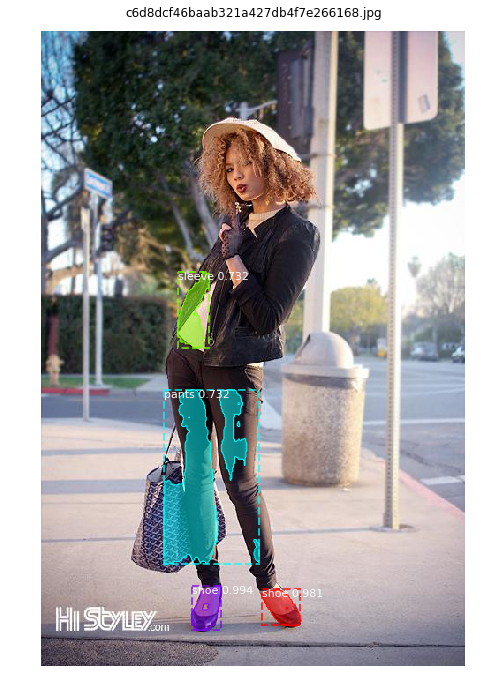

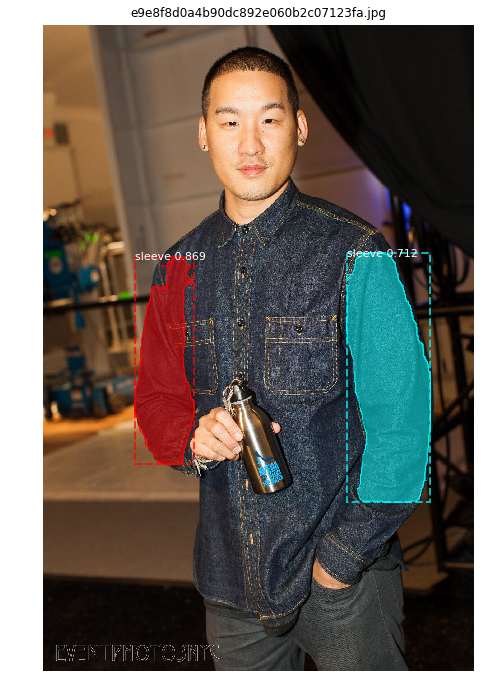

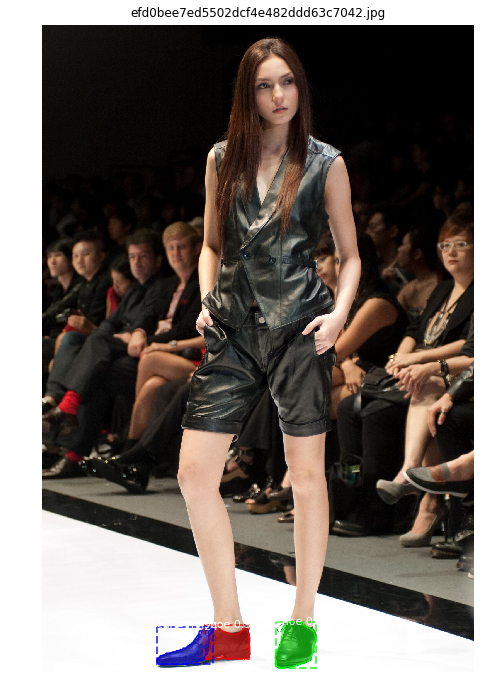

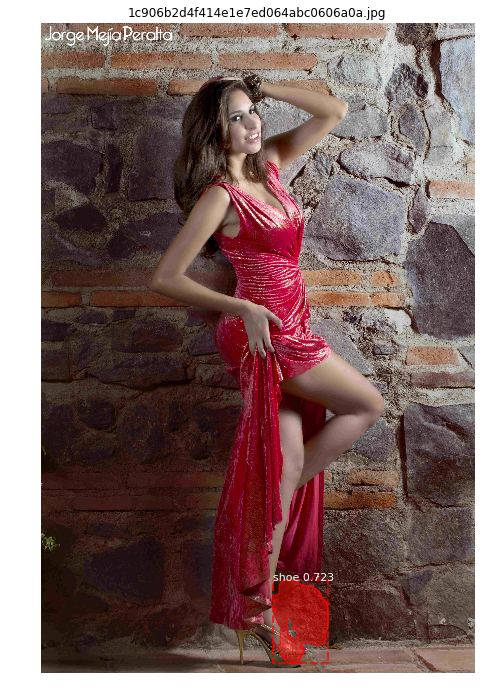

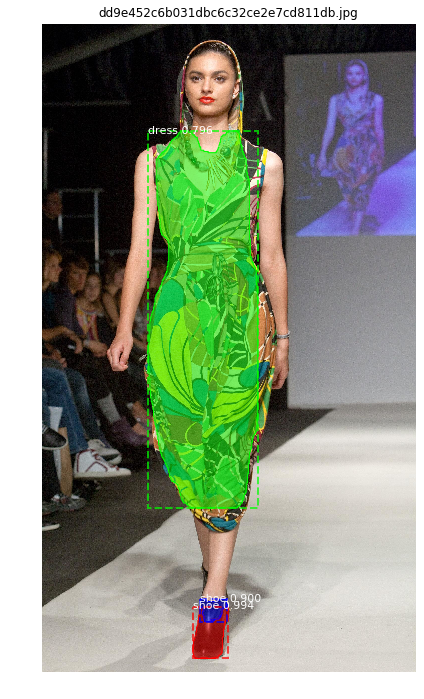

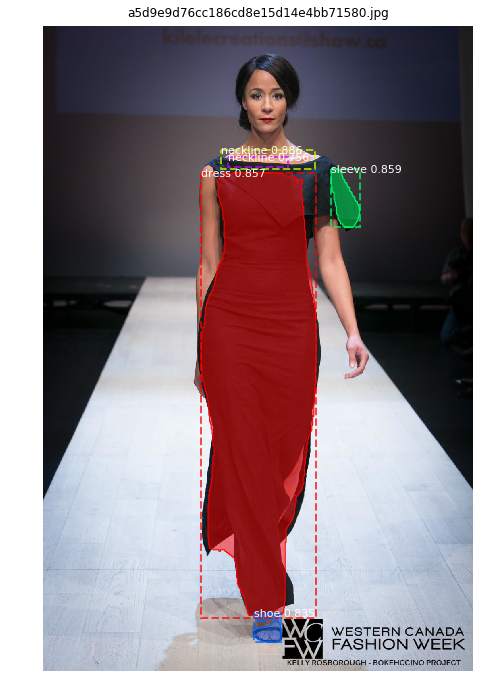

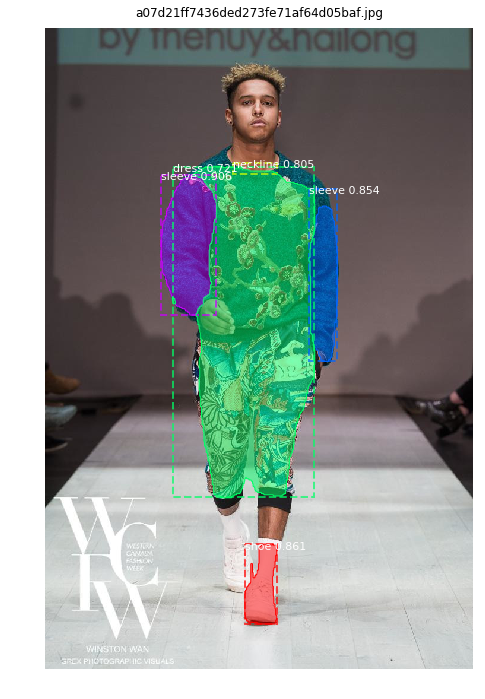

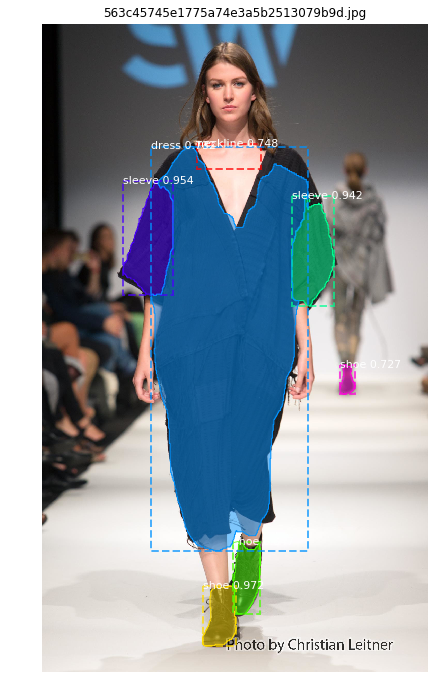

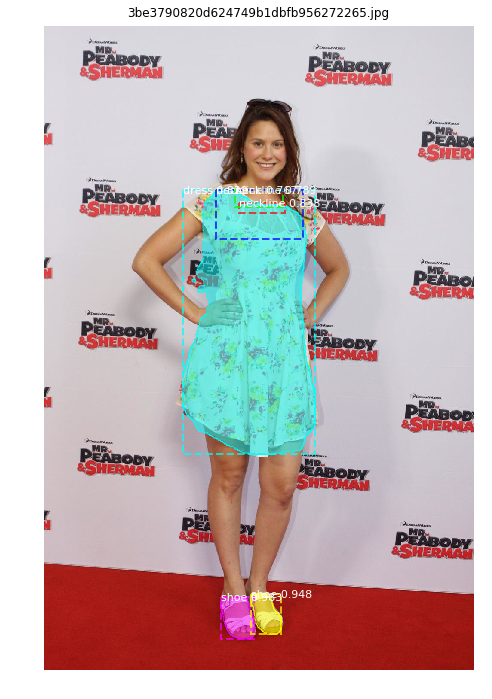

In [28]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = f'{DATA_DIR}/test/{image_id}'
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))